In [17]:
# Import necessary libraries
import numpy as np  # Import NumPy for handling numerical operations
import pandas as pd  # Import Pandas for data manipulation and analysis
import warnings  # Import Warnings to suppress unnecessary warnings

# Suppress warning messages
warnings.filterwarnings("ignore")


# Import matplotlib for data visualization
import matplotlib.pyplot as plt

# Import mean_squared_error for evaluating model performance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Import train_test_split for splitting the data into training and testing sets
from sklearn.model_selection import train_test_split


# Import RareLabelEncoder from feature_engine.encoding for encoding categorical features
from feature_engine.encoding import RareLabelEncoder

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA

from pytorch_tabnet.tab_model import TabNetRegressor
import torch

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download the stopwords from NLTK
import nltk
nltk.download('stopwords')
nltk.download('punkt')

from gensim.models import Word2Vec

# Set Pandas options to display a maximum of 1000 rows
pd.set_option('display.max_rows', 1000)
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maxim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maxim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [18]:
df2 = pd.read_csv('airbnb-listings.csv', delimiter = ';').drop(['ID', 'Listing Url', 'Scrape ID', 'Last Scraped'], axis=1)
df2.head()

,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,Notes,Transit,Access,Interaction,...,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
0,"Luxurious 3 bedroom, centrum, 180m2",‪This luxurious apartment is situated in the c...,In the heart of hip & lively Amsterdam Centrum...,‪This luxurious apartment is situated in the c...,none,There is a wide variety of cafes and restauran...,Perfect location to enjoy Amsterdam's famous e...,NaN,NaN,NaN,...,10.0,10.0,9.0,NaN,Amsterdam,strict,1.0,1.52,"52.36523660409065, 4.878249575101092","Host Has Profile Pic,Host Identity Verified,Is..."
1,Luxury apartment in city centre,"Beautiful, large (105m2, 2 floors) and quiet a...",1 living room 1 dining room 2 bedrooms 1 bathr...,"Beautiful, large (105m2, 2 floors) and quiet a...",none,Within a few minutes walking you'll be in the ...,NaN,Public transport is very close - 100 meters,NaN,You'll have the apartment for yourselves,...,10.0,10.0,9.0,NaN,Amsterdam,strict,1.0,0.81,"52.367309030897516, 4.8738407410699915","Host Is Superhost,Host Has Profile Pic,Host Id..."
2,Cosy apartment across Vondelpark,This central located apartment will make you f...,NaN,This central located apartment will make you f...,none,NaN,NaN,NaN,NaN,NaN,...,10.0,10.0,10.0,NaN,Amsterdam,flexible,1.0,0.05,"52.361943953804776, 4.866686522141489","Host Has Profile Pic,Host Identity Verified,Is..."
3,Spacious City Apartment Oud-West,Living like an Amsterdam resident in this ligh...,There are 2 bedrooms each with a double bed. I...,Living like an Amsterdam resident in this ligh...,none,The 85 m2 apartment is located on a quiet stre...,Do not hesitate to contact us with your questi...,A few important spots in the city: - van Gogh ...,"A Wi-Fi connection, cable TV/DVD and central h...",When we are present you can only rent the top ...,...,9.0,9.0,9.0,NaN,Amsterdam,flexible,1.0,0.62,"52.37014616115532, 4.866281767968382","Host Has Profile Pic,Host Identity Verified,Is..."
4,Cosy Studio Apartment Center Amsterdam,Studio Apartment Centre Amsterdam Perfect stud...,NaN,Studio Apartment Centre Amsterdam Perfect stud...,none,NaN,NaN,NaN,NaN,NaN,...,8.0,9.0,9.0,NaN,Amsterdam,moderate,1.0,2.04,"52.368817829014425, 4.871249476925455",Host Has Profile Pic


### Text Preprocessing

In [19]:
%%time
# Read the dataset from a CSV file into a Pandas DataFrame
df = pd.read_csv('airbnb-listings.csv', delimiter = ';').drop(['ID', 'Listing Url', 'Scrape ID', 'Last Scraped'], axis=1)
item0 = df.shape[0]  # Stores the initial number of rows in the DataFrame
df = df.drop_duplicates()  # Removes duplicate rows from the DataFrame
item1 = df.shape[0]  # Stores the number of rows after removing duplicates
print(f"There are {item0-item1} duplicates found in the dataset")  # Prints the number of duplicates that were removed

# Select only record with given price
df = df[df['Price']>0]

# Replace some locations with more common values
replacement_dict = {'Αθήνα, Greece': 'Athens, Greece',
                    'Athina, Greece': 'Athens, Greece',
                    'Roma, Italy': 'Rome, Italy',
                    'Venezia, Italy': 'Venice, Italy',
                    'København, Denmark': 'Copenhagen, Denmark',
                    'Montréal, Canada': 'Montreal, Canada',
                    'Ville de Québec, Canada': 'Québec, Canada',
                    'Genève, Switzerland': 'Geneva, Switzerland',
                    'Palma, Spain': 'Palma de Mallorca, Spain',
                    'Wien, Austria': 'Vienna, Austria',
                    'Greater London, United Kingdom': 'London, United Kingdom'
                   }
df['Smart Location'] = df['Smart Location'].replace(replacement_dict).fillna('None').astype(str)

There are 0 duplicates found in the dataset
CPU times: total: 46.9 s
Wall time: 50.5 s


In [20]:
%%time
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)
    # Convert to lower case and remove punctuation
    tokens = [word.lower() for word in tokens if word.isalpha()]
    # Remove stop words
    tokens = [word for word in tokens if not word in stop_words]
    return tokens

df = df.dropna(subset=['Description'])
df['processed_description'] = df['Description'].apply(preprocess_text)

CPU times: total: 7min 13s
Wall time: 7min 18s


### Embedding Generation

In [21]:
# Train Word2Vec on your corpus
model_w2v = Word2Vec(sentences=df['processed_description'].tolist(), vector_size=300, window=5, min_count=1, workers=4)
model_w2v.save("word2vec.model")

def get_vector(words):
    vector = []
    for word in words:
        vector.append(model_w2v.wv[word])
    return np.mean(vector, axis=0) if len(vector) > 0 else np.zeros(300)

df['embedding'] = df['processed_description'].apply(get_vector)

collecting all words and their counts
PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
PROGRESS: at sentence #10000, processed 760008 words, keeping 32815 word types
PROGRESS: at sentence #20000, processed 1505779 words, keeping 46769 word types
PROGRESS: at sentence #30000, processed 2285798 words, keeping 62209 word types
PROGRESS: at sentence #40000, processed 3040684 words, keeping 71453 word types
PROGRESS: at sentence #50000, processed 3824325 words, keeping 79956 word types
PROGRESS: at sentence #60000, processed 4567453 words, keeping 87076 word types
PROGRESS: at sentence #70000, processed 5342996 words, keeping 93291 word types
PROGRESS: at sentence #80000, processed 6123072 words, keeping 100080 word types
PROGRESS: at sentence #90000, processed 6908426 words, keeping 106327 word types
PROGRESS: at sentence #100000, processed 7682968 words, keeping 111439 word types
PROGRESS: at sentence #110000, processed 8440251 words, keeping 117018 word types
PROGRESS: a

In [22]:
# Show only selected columns
selected_cols = ['Price', 'Smart Location', 'Room Type', 'Property Type', 'Bed Type', 'Availability 365', 'Minimum Nights', 'Number of Reviews', 'Review Scores Rating', 'Cancellation Policy', 'embedding']
df = df[selected_cols]
print(df.shape)  # Prints the dimensions (rows and columns) of the filtered DataFrame
df.sample(5).T

(486819, 11)


,85305,438929,368344,286576,88927
Price,100.0,30.0,85.0,57.0,300.0
Smart Location,"Venice, Italy","Paris, France","Pakenham Upper, Australia","Rome, Italy","Venice, Italy"
Room Type,Entire home/apt,Private room,Entire home/apt,Entire home/apt,Entire home/apt
Property Type,Apartment,Apartment,House,Apartment,Apartment
Bed Type,Real Bed,Real Bed,Real Bed,Real Bed,Real Bed
Availability 365,306.0,321.0,181.0,164.0,102.0
Minimum Nights,2.0,1.0,1.0,3.0,2.0
Number of Reviews,90.0,21.0,0.0,73.0,11.0
Review Scores Rating,99.0,94.0,NaN,98.0,60.0
Cancellation Policy,strict_new,flexible,flexible,moderate_new,moderate_new


### Add Embeddings to Dataset with PCA

In [23]:
# PCA reduction
embeddings = np.vstack(df['embedding'].values)
pca = PCA(n_components=50)  # Adjust n_components as needed
reduced_embeddings = pca.fit_transform(embeddings)
for i in range(reduced_embeddings.shape[1]):
    df[f'pca_{i}'] = reduced_embeddings[:, i]

# Dropping original and intermediate columns used for embedding
df = df.drop(columns=['embedding'])  # Adjust column names as needed

### Encoding

In [24]:
# Define the main label column as 'Price'
main_label = 'Price'

# Exclude the 1% of the smallest and 1% of the highest labels in the DataFrame
P = np.percentile(df[main_label], [1, 99])
df = df[(df[main_label] > P[0]) & (df[main_label] < P[1])]

# Function to bin numerical columns into equal quantile-based bins
def bin_column(df, col_name, num_bins=7):
    # Calculate the bin edges to evenly split the numerical column
    bin_edges = pd.qcut(df[col_name], q=num_bins, retbins=True)[1]

    # Define labels for the categorical bins based on bin edges
    bin_labels = [f'{int(bin_edges[i])}-{int(bin_edges[i+1])}' for i in range(num_bins)]

    # Use pd.qcut to create quantile-based bins with an equal number of records in each bin
    df[col_name] = pd.qcut(df[col_name], q=num_bins, labels=False)

    # Update the bin labels to be more descriptive
    df[col_name] = df[col_name].map(lambda x: bin_labels[x])

    # Convert the column to object dtype
    df[col_name] = df[col_name].astype('object')

    return df

# Iterate through DataFrame columns (excluding the main label column)
for col in df.columns:
    if col != main_label:
        try:
            # Bin the column if it's numerical
            df = bin_column(df, col)
            print(f"Binned column {col}")
        except:
            # If not numerical, handle as categorical and apply RareLabelEncoder
            df[col] = df[col].fillna('None').astype(str).apply(lambda x: x.rstrip('.0'))
            encoder = RareLabelEncoder(n_categories=1, max_n_categories=70, replace_with='Other', tol=50/df.shape[0])
            df[col] = encoder.fit_transform(df[[col]])
            print(f"LabelEncoded column {col}")

# Print the shape of the resulting DataFrame
print(df.shape)

# Display a sample of 5 rows from the DataFrame, transposed for easier viewing
df.sample(5).T

LabelEncoded column Smart Location
LabelEncoded column Room Type
LabelEncoded column Property Type
LabelEncoded column Bed Type
LabelEncoded column Availability 365
LabelEncoded column Minimum Nights
LabelEncoded column Number of Reviews
LabelEncoded column Review Scores Rating
LabelEncoded column Cancellation Policy
Binned column pca_0
Binned column pca_1
Binned column pca_2
Binned column pca_3
Binned column pca_4
Binned column pca_5
Binned column pca_6
Binned column pca_7
Binned column pca_8
Binned column pca_9
Binned column pca_10
Binned column pca_11
Binned column pca_12
Binned column pca_13
Binned column pca_14
Binned column pca_15
Binned column pca_16
Binned column pca_17
Binned column pca_18
Binned column pca_19
Binned column pca_20
Binned column pca_21
Binned column pca_22
Binned column pca_23
Binned column pca_24
Binned column pca_25
Binned column pca_26
Binned column pca_27
Binned column pca_28
Binned column pca_29
Binned column pca_30
Binned column pca_31
Binned column pca_3

,188480,406327,174395,207968,228174
Price,50.0,121.0,185.0,48.0,22.0
Smart Location,"Paris, France",Other,"San Francisco, CA","Amsterdam, Netherlands","San Francisco, CA"
Room Type,Private room,Entire home/apt,Entire home/apt,Private room,Private room
Property Type,Bed & Breakfast,House,Apartment,Apartment,Apartment
Bed Type,Real Bed,Real Bed,Real Bed,Real Bed,Real Bed
Availability 365,,4,Other,Other,
Minimum Nights,1,2,29,3,9
Number of Reviews,,5,Other,43,
Review Scores Rating,None,1,94,96,None
Cancellation Policy,flexible,moderate,strict,moderate,moderate


In [30]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,473943.0,131.678101,128.180126,21.0,56.0,90.0,150.0,800.0
Smart Location,473943.0,33.900994,18.388442,0.0,21.0,37.0,44.0,70.0
Room Type,473943.0,0.381816,0.517564,0.0,0.0,0.0,1.0,2.0
Property Type,473943.0,3.677727,6.278256,0.0,0.0,0.0,9.0,23.0
Bed Type,473943.0,3.942826,0.352475,0.0,4.0,4.0,4.0,4.0
Availability 365,473943.0,44.506700,28.913020,0.0,11.0,57.0,70.0,70.0
Minimum Nights,473943.0,9.103930,8.038420,0.0,0.0,9.0,17.0,26.0
Number of Reviews,473943.0,20.076186,23.335334,0.0,1.0,11.0,32.0,70.0
Review Scores Rating,473943.0,30.454114,16.289399,0.0,24.0,37.0,44.0,45.0
Cancellation Policy,473943.0,3.201845,1.736114,0.0,1.0,3.0,5.0,8.0


### Data Initialization

In [31]:
# Encode categorical columns
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Extract target variable and features
y = df['Price'].values
X = df.drop(columns=['Price'])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(379154, 59) (94789, 59) (379154,) (94789,)


### Model Train

In [32]:
# Initialize TabNet regressor
regressor = TabNetRegressor(optimizer_fn=torch.optim.Adam,
                            optimizer_params=dict(lr=2e-2),
                            scheduler_params={"step_size":10, "gamma":0.9},
                            scheduler_fn=torch.optim.lr_scheduler.StepLR,
                            mask_type='entmax'
)

# Train the regressor
regressor.fit(
  X_train.values, y_train.reshape(-1, 1),
  eval_set=[(X_test.values, y_test.reshape(-1, 1))],
  patience=30,  # Stop training if the loss does not decrease for 10 consecutive epochs
  max_epochs=300
)

epoch 0  | loss: 13062.89457| val_0_mse: 8423.95845|  0:00:41s
epoch 1  | loss: 8441.53703| val_0_mse: 7898.87095|  0:01:19s
epoch 2  | loss: 8085.90542| val_0_mse: 7799.48218|  0:01:58s
epoch 3  | loss: 7889.65835| val_0_mse: 7570.48542|  0:02:40s
epoch 4  | loss: 7767.97101| val_0_mse: 7593.2131|  0:03:21s
epoch 5  | loss: 7664.09795| val_0_mse: 7422.84671|  0:04:03s
epoch 6  | loss: 7591.69783| val_0_mse: 7417.21644|  0:04:42s
epoch 7  | loss: 7543.50552| val_0_mse: 7387.28995|  0:05:24s
epoch 8  | loss: 7502.6485| val_0_mse: 7439.88279|  0:06:03s
epoch 9  | loss: 7459.55768| val_0_mse: 7365.02701|  0:06:41s
epoch 10 | loss: 7412.7278| val_0_mse: 7305.26252|  0:07:19s
epoch 11 | loss: 7373.85378| val_0_mse: 7239.45337|  0:07:57s
epoch 12 | loss: 7354.99317| val_0_mse: 7199.80873|  0:08:35s
epoch 13 | loss: 7322.57379| val_0_mse: 7254.90916|  0:09:13s
epoch 14 | loss: 7300.97445| val_0_mse: 7213.24091|  0:09:52s
epoch 15 | loss: 7279.33138| val_0_mse: 7197.17559|  0:10:30s
epoch 16 |

In [33]:
regressor.save_model('tabnet_NLP_model')

Successfully saved model at tabnet_NLP_model.zip


'tabnet_NLP_model.zip'

In [34]:
# Make predictions
y_train_pred = regressor.predict(X_train.values)
y_test_pred = regressor.predict(X_test.values)

# Calculate performance metrics
mse_train = mean_squared_error(y_train, y_train_pred, squared=False)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

mse_test = mean_squared_error(y_test, y_test_pred, squared=False)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print the metrics
print(f"Training Data Metrics:\nMSE: {round(mse_train,2)}\nMAE: {round(mae_train,2)}\nR2 Score: {round(r2_train,2)}")
print(f"\nTesting Data Metrics:\nMSE: {round(mse_test,2)}\nMAE: {round(mae_test,2)}\nR2 Score: {round(r2_test,2)}")

Training Data Metrics:
MSE: 78.41
MAE: 47.15
R2 Score: 0.63

Testing Data Metrics:
MSE: 81.02
MAE: 48.21
R2 Score: 0.6


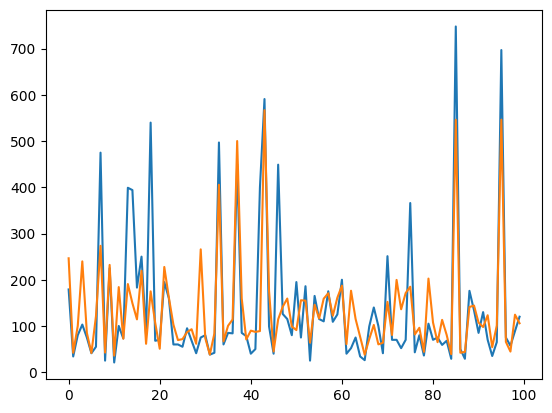

In [35]:
from IPython.display import display

plt.plot(y_test[:100])
plt.plot(y_test_pred[:100], label='y_test_pred')
plt.show()

# display(y_test[:20])
# display(y_test_pred[:20])